# Tutorial

The goal of this tutorial is to show how to set up and analyse a simulation using the `dompap` package.
After completing this tutorial, you should be able to:

- Set initial positions of particles
- Set initial velocities of particles
- Set the pair potential of the particles
- Set up the integrator (time step, target temperature etc.).
- Equilibrate the simulation
- Make a production run
- Visualise the simulation
- Compute thermodynamic properties of the system (pressure, energy, etc.)
- Compute and plot the radial distribution function.

For other tasks, such as setting up different models, and other analysis you should consult the examples in the documentation. 

## Introduction
This tutorial will show how to set up, and analyse a simulation.
We will simulate a three-dimensional system of particles with harmonic repulsions
These are particles that interact with the pair energy
\begin{equation}
   v(r) = (1-r)^2
\end{equation}
for $r<1$ and zero otherwise.

In [64]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import dompap  # Import the dompap package

First, we need to import the `Simulation` class from the `dompap` module, and create an instance of it.

In [2]:
sim = dompap.Simulation()  # Create an instance of the Simulation class

## Pair potential
We can set (and plot) the pair potential of the particles of the current simulation object.

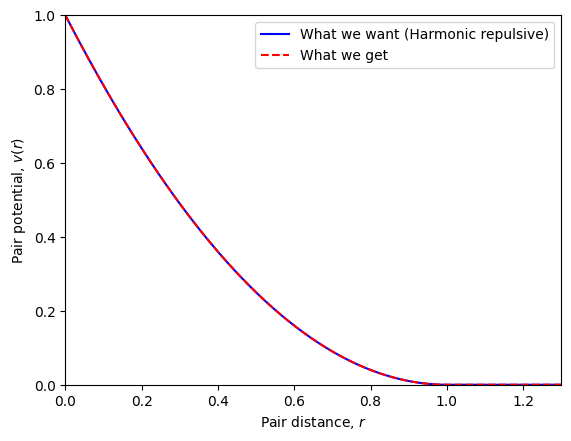

In [54]:
# Set pair potential
sim.set_pair_potential(pair_potential_str='(1-r)**2',
                       r_cut=1.0,
                       force_method='neighbor list',
                       energy_method='neighbor list')
sim.set_pair_potential_parameters(sigma=1.0, epsilon=1.0)

# Plot pair potential
plt.figure()
r = np.linspace(0.0, 2, 200)
v_test = (1-r)**2*np.heaviside(1.0-r, 0.5)
plt.plot(r, v_test, 'b-', label='What we want (Harmonic repulsive)')
plt.plot(r, sim.pair_potential(r), 'r--', label='What we get')
plt.xlabel(r'Pair distance, $r$')
plt.ylabel('Pair potential, $v(r)$')
plt.ylim(0, 1)
plt.xlim(0, 1.3)
plt.legend()
plt.show()

## Set initial positions and velocities
Next we set positions into an fcc lattice.

In [55]:
fcc_unit_cell = ([0.0, 0.0, 0.0],
                 [0.5, 0.5, 0.0],
                 [0.5, 0.0, 0.5],
                 [0.0, 0.5, 0.5])
sim.set_positions(unit_cell_coordinates=fcc_unit_cell,
                  cells=(5, 5, 5),
                  lattice_constants=(1.0, 1.0, 1.0))

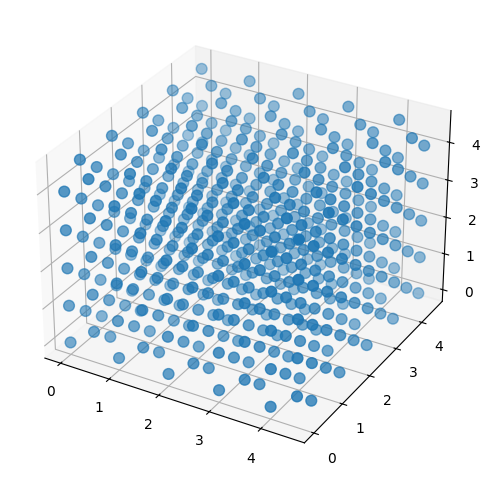

In [56]:
# Extract positions
x, y, z = sim.positions[:, 0], sim.positions[:, 1], sim.positions[:, 2]

# ... and create a 3d scatter plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=60)
plt.show()

Set masses and initial velocities.

In [77]:
sim.set_masses(masses=1.0)
sim.set_random_velocities(temperature=0.1)

Setup $NVE$ integrator (`temperature_damping_time=np.inf`) and parameters for neighbour list.

In [78]:
sim.set_integrator(time_step=0.01,
                   target_temperature=0.1,
                   temperature_damping_time=0.1)

## Autotuner

Use autotuner to set algorithm and parameters for most efficient calculations (can also be set manually).

Time to update neighbor list (double loop): 45.261 milliseconds
Time to update neighbor list (double loop): 45.983 milliseconds
Time to update neighbor list (double loop): 44.545 milliseconds
Time to update neighbor list (double loop): 45.210 milliseconds
Time to update neighbor list (cell list): 59.951 milliseconds
Time to update neighbor list (cell list): 61.856 milliseconds
Time to update neighbor list (cell list): 61.432 milliseconds
Time to update neighbor list (cell list): 61.142 milliseconds
Fastest method to update neighbor list: double loop
largest_allowed_skin=np.float64(2.5)
Skin | Time per step (ms) | steps/updates
 0.1 | 9.8612             | 100/22 = 4.5
 0.2 | 4.9336             | 100/11 = 9.1
 0.3 | 3.2483             | 100/7 = 14.3
 0.4 | 2.4621             | 100/5 = 20.0
 0.5 | 1.9850             | 100/4 = 25.0
 0.6 | 1.6825             | 100/3 = 33.3
 0.7 | 1.7786             | 100/3 = 33.3
Optimal parameters: skin=0.6
Time to compute forces (double loop, skin=0.6000)

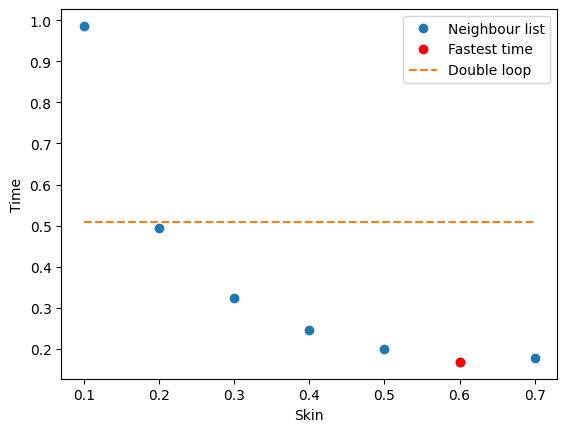

In [79]:
sim = dompap.tools.autotune(sim, verbose=True, plot=True)

## Run simluation


In [82]:
steps = 40
for step in range(steps):
    sim.step()
    if step % 10 == 0:
        print(f'Energy after {step} steps: {sim.get_potential_energy()}')

Energy after 0 steps: 284.6971446709218
Energy after 10 steps: 283.74305250653214
Energy after 20 steps: 282.90243536991017
Energy after 30 steps: 282.4926953341589


## Runtime analysis

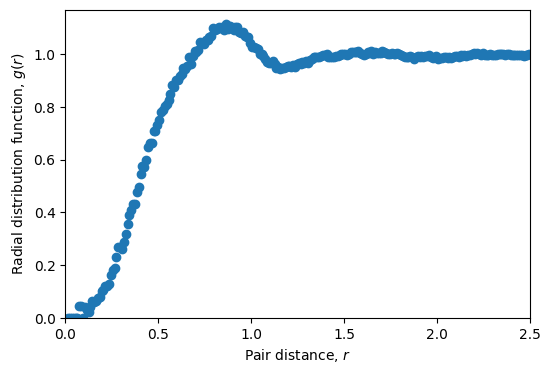

In [84]:
r_bins = np.arange(0.01, 2.5, 0.01)
r, rdf = sim.get_radial_distribution_function(r_bins=r_bins)
rdf_evaluations = 1
steps = 1_000
stride = 4
for step in range(steps):
    sim.step()
    if step % stride == 0:
        _, this_rdf = sim.get_radial_distribution_function(r_bins=r_bins)
        rdf += this_rdf
        rdf_evaluations += 1
rdf /= rdf_evaluations + 1

# Plot radial distribution function
plt.figure(figsize=(6, 4))
plt.plot(r, rdf, 'o')
plt.xlabel(r'Pair distance, $r$')
plt.ylabel(r'Radial distribution function, $g(r)$')
plt.xlim(0, 2.5)
plt.ylim(0, None)
plt.savefig('radial_distribution.png', dpi=300, bbox_inches='tight')
plt.show()